# Project 1: Finding Lane Lines on the Road

## Function Library

In [44]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import random
import os
import glob
from moviepy.editor import VideoFileClip
from IPython.display import Markdown, display, HTML
%matplotlib inline

def printmd(string):
    display(Markdown(string))
    
def plot_image(img, title):
    global p_type
    begin = title.find(".") + 2
    fname = title[begin:]
    end = fname.find("\n")
    fname = fname[:end]
    fname = fname.replace(" ", "_")
    fname = 'media/' + fname + ".png"
    if p_type == 'images':
        printmd(title)
        plt.imshow(img, cmap='gray')
        plt.savefig(fname)
        plt.show()
    elif p_type == 'readme':
        print(title)
        print()
        print("![png](" + fname + ")")
        print()
    
def grayscale(img):
    #Applies the Grayscale transform
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    #Applies the Canny transform
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    #Applies a Gaussian Noise kernel
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255   
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
# img should be the output of a Canny transform.
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
# img is the output of the hough_lines(), An image with lines drawn on it.
    return cv2.addWeighted(initial_img, α, img, β, γ)

def extrapolate_lines(line_image, lines, lane_middle, y_EndPt1, y_EndPt2, thickness):
    global lane, mv_avg
# Initialize the variables
    left_x = []# Left lane line, x coordinates
    left_y = []# Left lane line, y coordinates
    right_x = [] # Right lane line, x coordinates
    right_y = [] # Right lane line, y coordinates
    x_vals = [] # Line segment x values
    y_vals = [] # Line segment y values
    for line in lines:
        for x1, y1, x2, y2 in line:
# Calculate each line's slope and length
            rise = abs(y2 - y1)
            run = abs(x2 - x1)
            slope = rise / run
            length = (rise**2 + run**2)**.5
            length = round(length)
# Filter line segments based on slope and length
            if slope > .5 and length >= 1:
                length += 1
                x_vals = [x1, x2]
                y_vals= [y1, y2]
# Fit the line segment
                z = np.polyfit(y_vals, x_vals, 1)
                f = np.poly1d(z)
                y_new = np.linspace(y1, y2, rise)
                x_new = f(y_new)
# Separate the line segments into left and right lane lines
                if x1 < lane_middle and x2 < lane_middle:
                    left_x.extend(x_new)
                    left_y.extend(y_new)
                elif x1 > lane_middle and x2 > lane_middle:
                    right_x.extend(x_new)
                    right_y.extend(y_new)
# Fit all the left and right segments to a straight line and draw them
    if len(right_x) > 0:
        lane = 'right'
        fitx(right_x, right_y, y_EndPt1, y_EndPt2)
    if len(left_x) > 0:
        lane = 'left'
        fitx(left_x, left_y, y_EndPt1, y_EndPt2)
    color = (0, 127, 255)
    cv2.line(line_image, (mv_avg[0][0], y_EndPt1), (mv_avg[0][1], y_EndPt2), color, thickness)
    color = (255, 0, 0)
    cv2.line(line_image, (mv_avg[1][0], y_EndPt1), (mv_avg[1][1], y_EndPt2), color, thickness)
    return

def fill_lane(img, y1, y2, thickness):
    global lane, mv_avg
    vertices = np.array([[(mv_avg[0][0] + thickness, y1),(mv_avg[0][1] + thickness, y2), \
            (mv_avg[1][1] - thickness, y2), (mv_avg[1][0] - thickness, y1)]], dtype=np.int32)
    cv2.fillPoly(img, vertices, (0, 255, 0))

# Fit and draw lines
def fitx(x_vals, y_vals, y_EndPt1, y_EndPt2):
    global lane, mv_avg
    past_wt = .9
    x = []
# Extrapolate the data
    z = np.polyfit(y_vals, x_vals, 1)
    f = np.poly1d(z)
# Create the Line Coordinates Array
    y_new = np.linspace(y_EndPt1, y_EndPt2, 2)
    x_new = f(y_new)
    x.append(int(x_new[0]))
    x.append(int(x_new[-1]))
    lane_idx = 0
    if lane == 'right': lane_idx = 1
    if mv_avg[lane_idx][0] == 0:
        mv_avg[lane_idx] = x[:]
    else:
        for i in range(2):
            if x[i] < mv_avg[lane_idx][i]:
                x[i] = max(x[i], mv_avg[lane_idx][i] - 10)
            else:
                x[i] = min(x[i],mv_avg[lane_idx][i] + 10)
            mv_avg[lane_idx][i] = int(x[i] * (1 - past_wt) +  mv_avg[lane_idx][i] * past_wt)
    return

def process_image(image):
    global p_type
    if p_type != "video":
        plot_image(image, "##### 1. Original Image" + str(comments[0]))

# To update process_image (for the videos), extract after this line
#-------------------------------------------------------------------
### INITIALIZE ###
# Grab the x and y size and make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
    color_select = np.copy(image)
    masked_image = np.copy(image)

#### MASK REGION ###
# Define the vertices of a trapazoid.
# Keep in mind the origin (x=0, y=0) is in the upper left
    mask_midpoint = 490
    mask_horizon = 350
    vertices = np.array([[(120,ysize),(mask_midpoint - 80, mask_horizon), \
                (mask_midpoint + 80, mask_horizon), (910,ysize)]], dtype=np.int32)
    masked_region = region_of_interest(masked_image, vertices)
    if not video: plot_image(masked_region, "##### 2. Region of Interest" + str(comments[1]))
    
### SELECT YELLOW OR WHITE OBJECTS ###    
    min_white_threshold = [215,170,170]
    min_yellow_threshold = [180, 150, 0]
    max_yellow_threshold = [255, 255, 120]

    thresholds = ((masked_region[:,:,0] < min_white_threshold[0]) \
            | (masked_region[:,:,1] < min_white_threshold[1]) \
            | (masked_region[:,:,2] < min_white_threshold[2])) \
            &(((masked_region[:,:,0] < min_yellow_threshold[0]) \
            | (masked_region[:,:,1] < min_yellow_threshold[1]) \
            | (masked_region[:,:,2] < min_yellow_threshold[2])) \
            |((masked_region[:,:,0] > max_yellow_threshold[0]) \
            | (masked_region[:,:,1] > max_yellow_threshold[1]) \
            | (masked_region[:,:,2] > max_yellow_threshold[2])))

    color_select[thresholds] = [0,0,0]
    gray_image = grayscale(color_select)
    if p_type != "video": plot_image(gray_image, "##### 3. Color Filter" + str(comments[2]))
    
### GAUSSIAN ###
    kernel_size = 9
    blur_gray_image = gaussian_blur(gray_image, kernel_size)
    if p_type != "video": plot_image(blur_gray_image, "##### 4. Gaussian Blur" + str(comments[3]))
    
### CANNY ###
    high_threshold = 255
    low_threshold = high_threshold/2
    edges = canny(blur_gray_image, low_threshold, high_threshold)
    if p_type != "video": plot_image(edges, "##### 5. Canny Edges" + str(comments[4]))

### HOUGH ###
# Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 10 # minimum number of pixels making up a line
    max_line_gap = 70    # maximum gap in pixels between connectable line segments
# Run Hough on edge detected image
    line_image = np.zeros_like(image)
    lines = hough_lines(edges, rho, theta, threshold, min_line_len, max_line_gap)
    if p_type != "video": 
        line_img = np.copy(image) * 0 # creating a blank to draw lines on
        draw_lines(line_img, lines)
        plot_image(line_img, "##### 6. Hough Lines" + str(comments[5]))
    
### HIGHLIGHT LANE ###
# Draw Extrapolated "lines"
    line_thickness = 10
    if lines != None:
        extrapolate_lines(line_image, lines, mask_midpoint, mask_horizon, ysize, line_thickness) 
    if p_type != "video": plot_image(line_image, "##### 7. Extrapolated Lines" + str(comments[6]))    
    
# Fill Lane with green
    fill_lane(line_image, mask_horizon, ysize, line_thickness)

# Draw the lane on the original image
    masked_image = weighted_img(line_image, image, .6, .4)
    if p_type != "video":
        plot_image(masked_image, "##### 8. Original image with Lane shaded" + str(comments[0]))
        return
    else:
        return masked_image

### COMMENTS ###
# Create comments for each step of the filtering process
comments = (['','\n\nThis filter masks everything except the lane.',\
             '\n\nThis filter masks everything except yellow and white colors.',\
             '\n\nThis algorithm removes sharp edges.', '\n This algorithm finds edges.',\
             '\n\nThis algorithm converts edges into lines.', \
             '\n\nThis algorithm extrapolates lines and uses moving average and sanity checking algorithms' \
             ' to eliminate frame jumping.'])

## Result of Filtering, Averaging and Extrapolation

### Images

##### 1. Original Image

test_images\whiteCarLaneSwitch.jpg

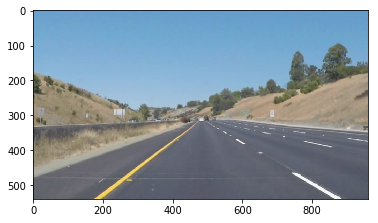

##### 2. Region of Interest

This filter masks everything except the lane.

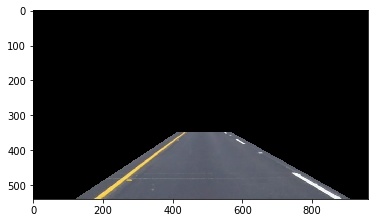

##### 3. Color Filter

This filter masks everything except yellow and white colors.

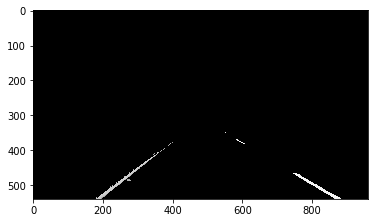

##### 4. Gaussian Blur

This algorithm removes sharp edges.

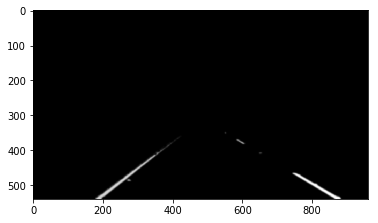

##### 5. Canny Edges
 This algorithm finds edges.

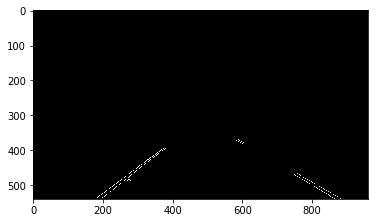

##### 6. Hough Lines

This algorithm converts edges into lines.

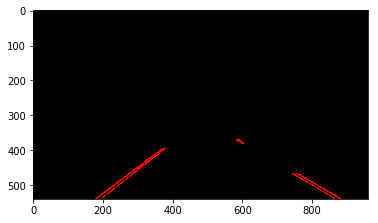

##### 7. Extrapolated Lines

This algorithm extrapolates lines and uses moving average and sanity checking algorithms to eliminate frame jumping.

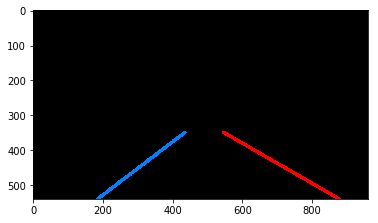

##### 8. Original image with Lane shaded

test_images\whiteCarLaneSwitch.jpg

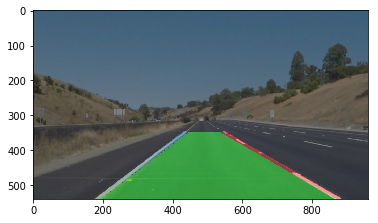

### Readme

##### 1. Original Image

test_images\whiteCarLaneSwitch.jpg

![png](media/Original_Image.png)

##### 2. Region of Interest

This filter masks everything except the lane.

![png](media/Region_of_Interest.png)

##### 3. Color Filter

This filter masks everything except yellow and white colors.

![png](media/Color_Filter.png)

##### 4. Gaussian Blur

This algorithm removes sharp edges.

![png](media/Gaussian_Blur.png)

##### 5. Canny Edges
 This algorithm finds edges.

![png](media/Canny_Edges.png)

##### 6. Hough Lines

This algorithm converts edges into lines.

![png](media/Hough_Lines.png)

##### 7. Extrapolated Lines

This algorithm extrapolates lines and uses moving average and sanity checking algorithms to eliminate frame jumping.

![png](media/Extrapolated_Lines.png)

##### 8. Original image with Lane shaded

test_images\whiteCarLaneSwitch.jpg

![png](media/Original_image_with_Lane_shaded.png)



In [57]:
# Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
global p_type
global lane, mv_avg
mv_avg = [[0 for col in range(2)] for row in range(2)]
# Read in the images
infilelist = []
for root, dirs, files in os.walk('test_images'):
    infilelist += glob.glob(os.path.join(root, '*.jpg'))

samples = random.sample(list(range(0, len(infilelist))), 1)
p_types = (["images", "readme"])
for i in range(2):
    p_type = p_types[i]
    printmd('### ' + p_type.capitalize())
    for j in samples:
        comments[0] = '\n\n' + infilelist[j]
        imagePic = cv2.imread(infilelist[j])
        imageRGB = cv2.cvtColor(imagePic, cv2.COLOR_BGR2RGB)
        image = cv2.resize(imageRGB, (960, 540))
        process_image(image)

# Show Videos

In [58]:
global p_type
p_type = "video"
video_list = ['solidWhiteRight.mp4', 'solidYellowLeft.mp4','challenge.mp4']
for i in range(len(video_list)):
    mv_avg = [[0 for col in range(2)] for row in range(2)]
    video_name = video_list[i]
    printmd('## ' + video_name)
    video_output = 'test_videos_output/' + video_name
    vclip = VideoFileClip('test_videos/' + video_name, target_resolution=(540, 960))
    out_clip = vclip.fl_image(process_image)
    out_clip.write_videofile(video_output, audio=False, verbose=False)
    out_clip.close

    display(HTML("""
    <video width="960" height="540" controls>
        <source src="{0}">
    </video>
    """.format(video_output)))

## solidWhiteRight.mp4

100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:59<00:00,  3.73it/s]


## solidYellowLeft.mp4

100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [03:20<00:00,  3.39it/s]


## challenge.mp4

100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [01:21<00:00,  3.07it/s]
